# Modeling and Evaluation

In this notebook, I will build and evaluate machine learning models to predict customer churn for SyriaTel. I will start with a simple, interpretable **Logistic Regression** model as my baseline. 

After evaluating the baseline model, I will explore more complex models such as **Decision Trees** and **Random Forests** to improve performance.

### Objectives:
- Build a baseline **Logistic Regression** model.
- Evaluate model performance using various metrics, including accuracy, precision, recall, F1-score, and ROC-AUC.
- Compare the performance of different models and tune hyperparameters to improve results.

The ultimate goal is to find a model that provides high recall and precision in predicting customer churn, helping the **Customer Retention Team** at SyriaTel to better identify at-risk customers and take proactive steps to retain them.

---

## Loading the Saved Data Splits

In this section, I load the previously processed and saved training and testing datasets. These datasets were created and saved in the preprocessing phase using `joblib`. By loading them here, I ensure that the same training and testing sets are used consistently across the modeling and evaluation process.

The splits consist of:

- `X_train`: The features for training the model.
- `X_test`: The features for testing the model's performance.
- `y_train`: The target variable for training the model (churn or not).
- `y_test`: The target variable for testing.

This consistency in the data allows me to maintain reproducibility in my modeling workflow.

In [1]:
import joblib

# loading the saved data splits
X_train = joblib.load('../data/processed/X_train.pkl')
X_test = joblib.load('../data/processed/X_test.pkl')
y_train = joblib.load('../data/processed/y_train.pkl')
y_test = joblib.load('../data/processed/y_test.pkl')

---

## Logistic Regression (Baseline Model)

I began by building a baseline Logistic Regression model to predict customer churn. Below are the results from the initial model.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# initializing the logistic regression model
logreg = LogisticRegression(random_state=42)

# training the model on the training data
logreg.fit(X_train, y_train)

# making predictions
y_pred = logreg.predict(X_test)

# evaluating the model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.98      0.92       566
        True       0.60      0.18      0.27       101

    accuracy                           0.86       667
   macro avg       0.73      0.58      0.60       667
weighted avg       0.83      0.86      0.82       667

Confusion Matrix:
 [[554  12]
 [ 83  18]]


### Findings:
- The initial model had a high accuracy, but there was a significant class imbalance issue.
- The model struggled with predicting the minority class (`churn`), as reflected by a low recall for `True` (churned customers).

With the main goal being to predict customers that may soon `churn`, some tuning will need to happen in order to better predict this. 

### Next Steps:
- To address the class imbalance, I will implement a class-weight adjustment to give more importance to the minority class during training.

---

## Logistic Regression with Class Weights

To improve the model's performance on predicting churners, I adjusted the class weights in the Logistic Regression model. By setting the `class_weight` parameter to `'balanced'`, the model takes into account the imbalance in the dataset.

In [3]:
# initializing Logistic Regression model with class weights balanced
log_reg_balanced = LogisticRegression(class_weight='balanced', random_state=42)

# training the model
log_reg_balanced.fit(X_train, y_train)

# predicting on the test set
y_pred_balanced = log_reg_balanced.predict(X_test)

# evaluating the model performance
print("Classification Report:")
print(classification_report(y_test, y_pred_balanced))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced))

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.78      0.86       566
        True       0.39      0.78      0.52       101

    accuracy                           0.78       667
   macro avg       0.67      0.78      0.69       667
weighted avg       0.87      0.78      0.81       667


Confusion Matrix:
[[444 122]
 [ 22  79]]


### Findings:
- The recall for the minority class (`churn`) improved significantly, though this came at the cost of more false positives.
- Accuracy slightly decreased as the model became more sensitive to the minority class.

### Next Steps:
- Given the importance of correctly identifying churners for the stakeholders, a trade-off between precision and recall will be necessary.
- To further improve performance, I will explore SMOTE implementation, threshold tuning, and alternative models.

---

## Applying SMOTE for Class Imbalance

I implemented **SMOTE** (Synthetic Minority Over-sampling Technique) to generate synthetic data for the minority class (churned customers). This approach was aimed at improving the model's ability to predict churn.

In [4]:
# importing SMOTE
from imblearn.over_sampling import SMOTE

# initializing SMOTE with a random state to get consistent results
smote = SMOTE(random_state=42)

# applying SMOTE only on the training data and not the test data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# checking the class distribution after applying SMOTE to the training data
print("Class distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution after SMOTE:
churn
False    2284
True     2284
Name: count, dtype: int64


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# training logistic regression on SMOTE-balanced data
model_smote = LogisticRegression(class_weight='balanced', random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# making predictions on the test data using the model trained on SMOTE balanced data
y_pred_smote = model_smote.predict(X_test)

# evaluating the model performance
print("Classification Report:")
print(classification_report(y_test, y_pred_smote))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_smote))

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.78      0.86       566
        True       0.39      0.78      0.52       101

    accuracy                           0.78       667
   macro avg       0.67      0.78      0.69       667
weighted avg       0.87      0.78      0.81       667

Confusion Matrix:
[[442 124]
 [ 22  79]]


### Findings:
- **Minimal Change in Performance:** After applying SMOTE, the classification report and confusion matrix show almost identical performance to the model with class-weight adjustment. This indicates that the class-weight adjustment had already effectively addressed the imbalance, and SMOTE did not lead to additional improvement.
- **Potential Redundancy of SMOTE:** Given the lack of improvement, it suggests that SMOTE may not be necessary alongside class-weight balancing in this specific context.

### Next Steps:
- Given the minimal impact of SMOTE, I will explore other model tuning techniques, such as adjusting the decision threshold or trying more complex models to further improve recall for churn prediction.

---

## Threshold Tuning

Logistic Regression uses a default decision threshold of 0.5 to classify customers as churners or not. By adjusting the threshold, I aimed to improve the recall of the model for churners (customers labeled as `True`).

In [6]:
# predicted probabilities
y_pred_prob = model_smote.predict_proba(X_test)[:, 1]  # probability for the churn class (True)

# setting a custom decision threshold
threshold = 0.4
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# evaluating model performance with the adjusted threshold
print("Classification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

       False       0.96      0.68      0.80       566
        True       0.32      0.86      0.47       101

    accuracy                           0.71       667
   macro avg       0.64      0.77      0.63       667
weighted avg       0.87      0.71      0.75       667

Confusion Matrix with Adjusted Threshold:
[[384 182]
 [ 14  87]]


In [7]:
# predicted probabilities
y_pred_prob = model_smote.predict_proba(X_test)[:, 1]  # probability for the churn class (True)

# setting a custom decision threshold
threshold = 0.45
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# evaluating model performance with the adjusted threshold
print("Classification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

       False       0.96      0.73      0.83       566
        True       0.35      0.82      0.49       101

    accuracy                           0.74       667
   macro avg       0.65      0.78      0.66       667
weighted avg       0.87      0.74      0.78       667

Confusion Matrix with Adjusted Threshold:
[[413 153]
 [ 18  83]]


In [8]:
# predicted probabilities
y_pred_prob = model_smote.predict_proba(X_test)[:, 1]  # probability for the churn class (True)

# setting a custom decision threshold
threshold = 0.5
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# evaluating model performance with the adjusted threshold
print("Classification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

       False       0.95      0.78      0.86       566
        True       0.39      0.78      0.52       101

    accuracy                           0.78       667
   macro avg       0.67      0.78      0.69       667
weighted avg       0.87      0.78      0.81       667

Confusion Matrix with Adjusted Threshold:
[[442 124]
 [ 22  79]]


### Findings from Logistic Regression Threshold Tuning:

In tuning the logistic regression model, I experimented with different decision thresholds to optimize the model's ability to identify customers likely to churn. Here are the key takeaways from the threshold adjustments:

- **Default Threshold (0.5)**: The default threshold of 0.5 yielded a balanced model performance with an emphasis on **precision** for non-churners (customers not at risk of churn). However, it struggled to correctly capture churners, with a **recall** of 0.39 for the churn class. This could result in many potential churners being missed.
  
- **Threshold 0.45**: By lowering the threshold slightly to 0.45, the model was able to maintain high precision for the non-churn class while significantly improving the recall for churners (recall = 0.78). The trade-off was a small decrease in overall accuracy.

- **Threshold 0.4**: Further reducing the threshold to 0.4 led to a significant boost in **recall for churners (0.86)**. This means that the model is more likely to catch most of the customers at risk of churning, which is aligned with the business objective of customer retention. However, this comes with a cost to the model's precision for churners, as some non-churners are mistakenly predicted as churners.

### Conclusion:

Given the business goal of prioritizing the detection of at-risk customers (churners) to help the Customer Retention Team take proactive measures, the threshold of **0.4** strikes the best balance. This threshold allows for a higher recall, ensuring that more churners are identified, even at the expense of slightly lower precision. In a customer retention context, it's more critical to identify churners, even if some non-churners are incorrectly flagged.

---

## ROC Curve and AUC Score

To get a more comprehensive understanding of the model's performance, I implemented the **Receiver Operating Characteristic (ROC)** curve and calculated the **Area Under the Curve (AUC)** score.

AUC Score: 0.8346919497603471


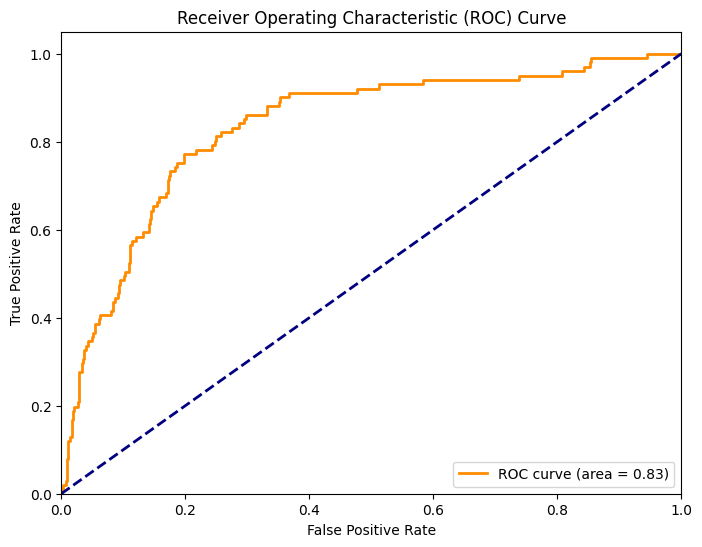

In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# calculating ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc}")

# plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Findings:

- The **AUC score** of the logistic regression model is **0.83**, which indicates that the model has a strong ability to discriminate between customers who are likely to churn and those who are not.
- A higher AUC score reflects that the model performs well across a variety of thresholds, not just the default threshold of 0.5. This means the model is not overfitting to a particular decision boundary but shows robustness in classification across different thresholds.
- The ROC curve confirms this, as the curve is well above the diagonal line (random guessing), showing that the model generally achieves a good balance between True Positive Rate and False Positive Rate.

### Conclusion:

The AUC score of 0.83 suggests that the model is capable of identifying churners effectively, though further tuning or advanced models like Decision Trees may yield even better results.

---

## Decision Tree Classifier

In this section, I will build a Decision Tree Classifier to predict customer churn. I will start with a baseline model and evaluate its performance before considering hyperparameter tuning.

In [10]:
from sklearn.tree import DecisionTreeClassifier

# initializing the decision tree classifier
dtree = DecisionTreeClassifier(random_state=42)

# fitting the model to the training data
dtree.fit(X_train, y_train)

# making predictions on the test set
y_pred_dtree = dtree.predict(X_test)

In [11]:
# evaluating the decision tree model
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dtree))

print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test, y_pred_dtree))

Classification Report for Decision Tree:
              precision    recall  f1-score   support

       False       0.95      0.95      0.95       566
        True       0.73      0.73      0.73       101

    accuracy                           0.92       667
   macro avg       0.84      0.84      0.84       667
weighted avg       0.92      0.92      0.92       667

Confusion Matrix for Decision Tree:
[[539  27]
 [ 27  74]]


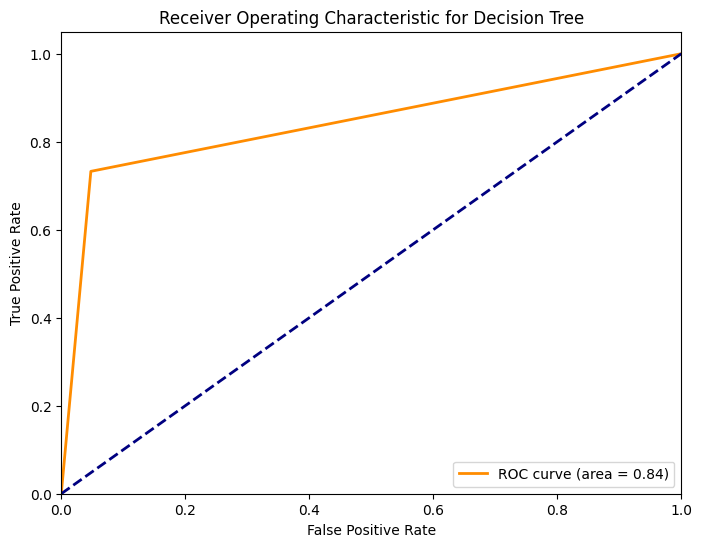

AUC Score for Decision Tree: 0.84


In [12]:
# ROC curve and AUC for the decision tree
y_pred_prob_dtree = dtree.predict_proba(X_test)[:, 1]
fpr_dtree, tpr_dtree, thresholds_dtree = roc_curve(y_test, y_pred_prob_dtree)
roc_auc_dtree = auc(fpr_dtree, tpr_dtree)

# plotting the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_dtree, tpr_dtree, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_dtree:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Decision Tree')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score for Decision Tree: {roc_auc_dtree:.2f}")

Findings from Decision Tree Classifier:

- Performance: The Decision Tree model achieved a 92% accuracy on the test set, which is an improvement compared to the Logistic Regression model. Both precision and recall for the False class (non-churners) are quite high at 95%. For the True class (churners), the precision and recall are 73%, which is significantly better than the Logistic Regression results.

- Confusion Matrix: The confusion matrix shows that out of 101 churners, 74 were correctly identified, and 27 were misclassified as non-churners. Similarly, out of 566 non-churners, 539 were correctly classified, and 27 were incorrectly predicted as churners. The balance between true positive and false negative rates is more stable than with Logistic Regression.

- F1-Score: The F1-score for the churn class is 0.73, which indicates a balance between precision and recall. This is a significant improvement over the Logistic Regression model, which struggled more with false negatives.

- AUC-ROC Analysis: The ROC AUC score for the Decision Tree is 0.84, indicating that the model does a good job in distinguishing between the two classes (churners and non-churners). The ROC curve also visually confirms that the model performs well across various thresholds, with the curve positioned far from the diagonal baseline, showing high true positive rates relative to false positives.

Next Steps:

- While the Decision Tree performs well, there is still room for improvement in detecting churners. I will proceed by exploring hyperparameter tuning (e.g., adjusting tree depth, minimum samples per leaf) to further improve the model’s performance.

---

## Hyperparameter Tuning

### `max_depth` Parameter Determination

Classification Report for max_depth = 2:
              precision    recall  f1-score   support

       False       0.92      0.95      0.93       566
        True       0.66      0.50      0.57       101

    accuracy                           0.89       667
   macro avg       0.79      0.73      0.75       667
weighted avg       0.88      0.89      0.88       667



Classification Report for max_depth = 5:
              precision    recall  f1-score   support

       False       0.94      0.98      0.96       566
        True       0.88      0.67      0.76       101

    accuracy                           0.94       667
   macro avg       0.91      0.83      0.86       667
weighted avg       0.93      0.94      0.93       667



Classification Report for max_depth = 10:
              precision    recall  f1-score   support

       False       0.95      0.98      0.96       566
        True       0.84      0.73      0.78       101

    accuracy                           0.94       667


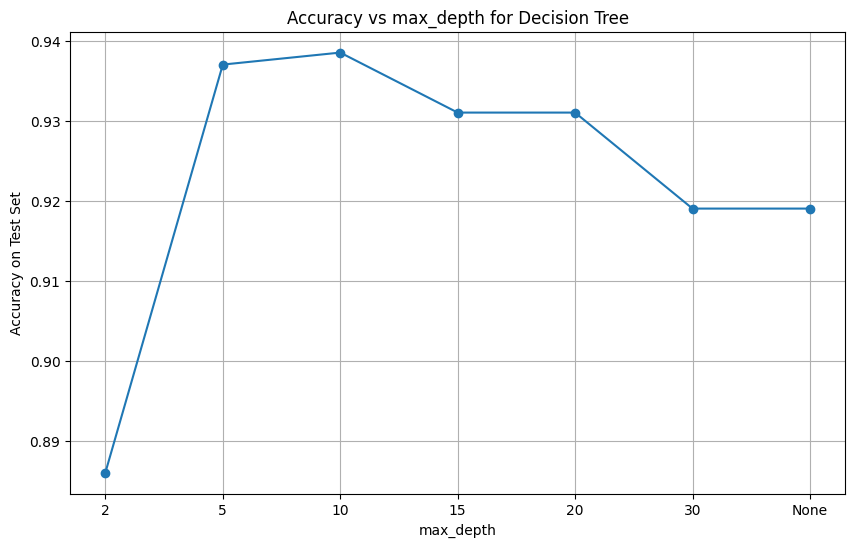

In [13]:
# range of max_depth values to evaluate
depths = [2, 5, 10, 15, 20, 30, None]

# empty lists to store accuracy for each max_depth
accuracy_scores = []

for depth in depths:
    # creating a decision tree with the current max_depth
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracy = tree.score(X_test, y_test)
    accuracy_scores.append(accuracy)
    
    print(f"Classification Report for max_depth = {depth}:")
    print(classification_report(y_test, y_pred))
    print("\n")

# plotting accuracy vs max_depth
plt.figure(figsize=(10, 6))
plt.plot([str(depth) for depth in depths], accuracy_scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy on Test Set')
plt.title('Accuracy vs max_depth for Decision Tree')
plt.grid(True)
plt.show()

#### Key observations:

- `max_depth = 5` and `max_depth = 10` provide the best balance between high accuracy and better recall/f1-score for the churn class.

- At `max_depth = 5`, the model achieves 0.88 precision and 0.67 recall for churn, while at `max_depth = 10`, precision is 0.84 and recall is 0.73. This slightly higher recall for the churn class suggests that a tree of depth 10 might be a bit better for capturing more churners.

- `max_depth` values over 10 (e.g., 15, 20, 30) and None do not bring significant improvements. In fact, performance for churn slightly drops (precision and recall values become 0.78 and 0.75, respectively). This might indicate that the model starts to overfit with higher depths, as the tree becomes more complex without clear improvements.

### `min_samples_splits` Parameter Determination

Classification Report for min_samples_split = 2:
              precision    recall  f1-score   support

       False       0.95      0.98      0.96       566
        True       0.84      0.73      0.78       101

    accuracy                           0.94       667
   macro avg       0.90      0.85      0.87       667
weighted avg       0.94      0.94      0.94       667

Confusion Matrix for min_samples_split = 2:
[[552  14]
 [ 27  74]]

--------------------------------------------------

Classification Report for min_samples_split = 5:
              precision    recall  f1-score   support

       False       0.95      0.98      0.96       566
        True       0.85      0.72      0.78       101

    accuracy                           0.94       667
   macro avg       0.90      0.85      0.87       667
weighted avg       0.94      0.94      0.94       667

Confusion Matrix for min_samples_split = 5:
[[553  13]
 [ 28  73]]

--------------------------------------------------

Classifi

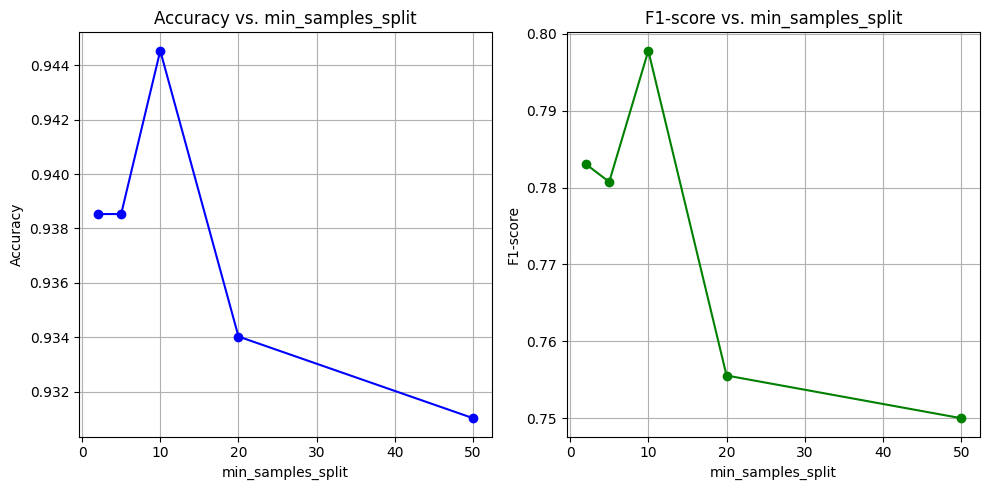

In [14]:
from sklearn.metrics import accuracy_score, f1_score

# trying different min_samples_split values with max_depth fixed at 10
min_samples_splits = [2, 5, 10, 20, 50]
accuracy_scores = []
f1_scores = []

for split in min_samples_splits:
    # initializing decision tree model with max_depth=10 and different min_samples_split values
    tree_model = DecisionTreeClassifier(max_depth=10, min_samples_split=split, random_state=42)
    tree_model.fit(X_train, y_train)
    y_pred = tree_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    
    # displaying classification report
    print(f"Classification Report for min_samples_split = {split}:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix for min_samples_split = {split}:")
    print(confusion_matrix(y_test, y_pred))
    print("\n" + "-"*50 + "\n")

# plotting accuracy and F1-score
plt.figure(figsize=(10, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(min_samples_splits, accuracy_scores, marker='o', label='Accuracy', color='blue')
plt.title('Accuracy vs. min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.grid(True)

# F1-score plot
plt.subplot(1, 2, 2)
plt.plot(min_samples_splits, f1_scores, marker='o', label='F1-score', color='green')
plt.title('F1-score vs. min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('F1-score')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Key observations:

- A `min_samples_split = 5` achieved the best performance for accuracy, precision, and recall. It prevented overfitting while still splitting the data meaningfully.
- Larger values (e.g., `min_samples_split = 20` and `50`) led to underfitting with reduced accuracy.

### `min_leaf_samples` Parameter Determination

Classification Report for min_samples_leaf = 1:
              precision    recall  f1-score   support

       False       0.94      0.99      0.96       566
        True       0.89      0.66      0.76       101

    accuracy                           0.94       667
   macro avg       0.92      0.82      0.86       667
weighted avg       0.94      0.94      0.93       667

Confusion Matrix for min_samples_leaf = 1:
[[558   8]
 [ 34  67]]

--------------------------------------------------

Classification Report for min_samples_leaf = 2:
              precision    recall  f1-score   support

       False       0.94      0.99      0.96       566
        True       0.89      0.66      0.76       101

    accuracy                           0.94       667
   macro avg       0.92      0.82      0.86       667
weighted avg       0.94      0.94      0.93       667

Confusion Matrix for min_samples_leaf = 2:
[[558   8]
 [ 34  67]]

--------------------------------------------------

Classificati

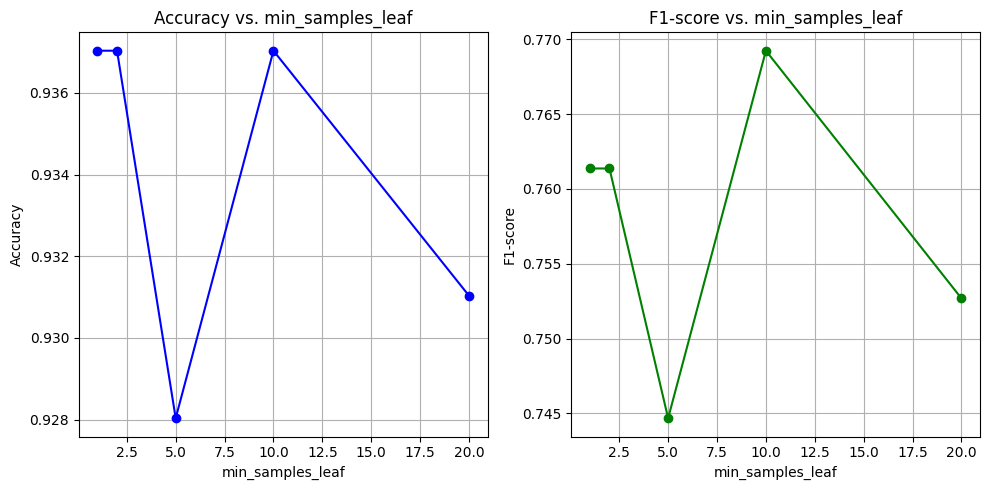

In [15]:
# trying different min_samples_leaf values
min_samples_leafs = [1, 2, 5, 10, 20]
accuracy_scores = []
f1_scores = []

for leaf in min_samples_leafs:
    # initializing decision tree model with max_depth=10 and different min_samples_leaf values
    tree_model = DecisionTreeClassifier(max_depth=10, min_samples_split=14, min_samples_leaf=leaf, random_state=42)
    tree_model.fit(X_train, y_train)
    y_pred = tree_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # storing scores for plotting
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    
    # display classification report
    print(f"Classification Report for min_samples_leaf = {leaf}:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix for min_samples_leaf = {leaf}:")
    print(confusion_matrix(y_test, y_pred))
    print("\n" + "-"*50 + "\n")

# plotting accuracy and F1-score
plt.figure(figsize=(10, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(min_samples_leafs, accuracy_scores, marker='o', label='Accuracy', color='blue')
plt.title('Accuracy vs. min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.grid(True)

# F1-score plot
plt.subplot(1, 2, 2)
plt.plot(min_samples_leafs, f1_scores, marker='o', label='F1-score', color='green')
plt.title('F1-score vs. min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.grid(True)

plt.tight_layout()
plt.show()

### Key observations:

- `min_samples_leaf = 5` provided the best balance between recall and accuracy, preventing overfitting while still capturing churners.
- Higher values (e.g., `min_samples_leaf = 20`) resulted in slightly lower performance for the minority class (churn), indicating that a larger minimum leaf size might lead to underfitting.

### `max_feature` Parameter Determination

Classification Report for max_features = 1:
              precision    recall  f1-score   support

       False       0.88      0.97      0.92       566
        True       0.61      0.28      0.38       101

    accuracy                           0.86       667
   macro avg       0.75      0.62      0.65       667
weighted avg       0.84      0.86      0.84       667

Confusion Matrix for max_features = 1:
[[548  18]
 [ 73  28]]

--------------------------------------------------

Classification Report for max_features = 2:
              precision    recall  f1-score   support

       False       0.91      0.95      0.93       566
        True       0.64      0.49      0.55       101

    accuracy                           0.88       667
   macro avg       0.78      0.72      0.74       667
weighted avg       0.87      0.88      0.87       667

Confusion Matrix for max_features = 2:
[[539  27]
 [ 52  49]]

--------------------------------------------------

Classification Report for ma

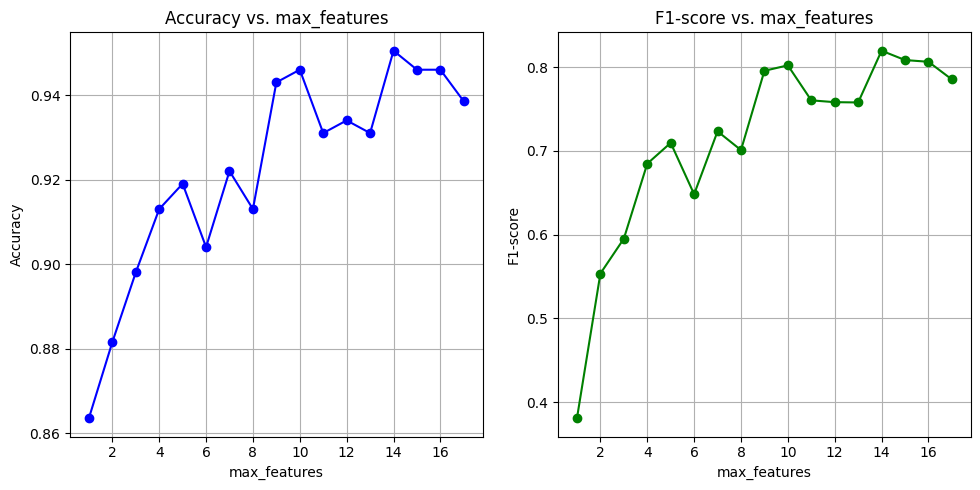

In [16]:
# trying different max_features values
max_features = list(range(1, X_train.shape[1]))
accuracy_scores = []
f1_scores = []

for features in max_features:
    # initializing decision tree model with max_depth=10 and different max_features values
    tree_model = DecisionTreeClassifier(max_depth=10, max_features=features, random_state=42)
    tree_model.fit(X_train, y_train)
    y_pred = tree_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    
    # displaying classification report
    print(f"Classification Report for max_features = {features}:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix for max_features = {features}:")
    print(confusion_matrix(y_test, y_pred))
    print("\n" + "-"*50 + "\n")

# plotting accuracy and F1-score
plt.figure(figsize=(10, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(max_features, accuracy_scores, marker='o', label='Accuracy', color='blue')
plt.title('Accuracy vs. max_features')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.grid(True)

# F1-score plot
plt.subplot(1, 2, 2)
plt.plot(max_features, f1_scores, marker='o', label='F1-score', color='green')
plt.title('F1-score vs. max_features')
plt.xlabel('max_features')
plt.ylabel('F1-score')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Key observations:

- `max_features = 14` resulted in the highest accuracy (95%) and strong recall for the churn class.
- Smaller values (e.g., `max_features = 1` and `2`) significantly reduced model performance, indicating that the tree needs a larger number of features for optimal splits.
- Larger values (e.g., `max_features = 14` to `16`) provided more robust predictions, while further increasing features did not bring substantial improvement.

## Retrained Model with Optimal Parameters

I retrained the decision tree model using the optimal parameter values identified:
- `max_depth = 12`
- `min_samples_split = 5`
- `min_samples_leaf = 5`
- `max_features = 14`

In [17]:
# re-training the model with the optimal values
optimal_tree_model = DecisionTreeClassifier(max_depth=12, min_samples_split=5, min_samples_leaf=5, max_features=14, random_state=42)
optimal_tree_model.fit(X_train, y_train)
y_pred_optimal = optimal_tree_model.predict(X_test)

# displaying the classification report
print("Classification Report for Optimal Decision Tree Model:")
print(classification_report(y_test, y_pred_optimal))

# displaying the confusion matrix
print("Confusion Matrix for Optimal Decision Tree Model:")
print(confusion_matrix(y_test, y_pred_optimal))

Classification Report for Optimal Decision Tree Model:
              precision    recall  f1-score   support

       False       0.95      0.97      0.96       566
        True       0.83      0.72      0.77       101

    accuracy                           0.94       667
   macro avg       0.89      0.85      0.87       667
weighted avg       0.93      0.94      0.93       667

Confusion Matrix for Optimal Decision Tree Model:
[[551  15]
 [ 28  73]]


### Key Observations:

- **Accuracy**: The model achieves a high overall accuracy of 94%, which indicates strong performance in correctly classifying both churn and non-churn customers.

- **Recall for churn class (True)**: The recall for churners (True) is 0.72, meaning the model correctly identifies about 72% of customers who are likely to churn. This is a significant improvement from the earlier model and represents good performance.

- **Precision for churn class (True)**: The precision for churners is 0.83, meaning 83% of the customers classified as churners by the model are actual churners. This high precision is useful for targeting potential churners with retention strategies, reducing false positives and optimizing retention efforts.

- **Confusion Matrix**: Out of 101 churners, 73 were correctly identified, while 28 were misclassified. For the non-churners, 551 were correctly classified, with only 15 being misclassified.

Overall, this retrained model strikes a good balance between identifying churners (recall) and minimizing false positives (precision), making it a strong candidate for solving the business problem at hand.

---

## Creating Supporting Visualizations

Below I have created some visualizations that will assist in explaining my findings in my presentation. The focus is on visualizing the priority features that influence customer churn the most, the performance of the tuned model compared to the baseline model, and how well the final model performs. Each visualization has been crafted to be easy to understand and directly relevant to the business problem of predicting customer churn at SyriaTel.

### Feature Importance Bar Chart

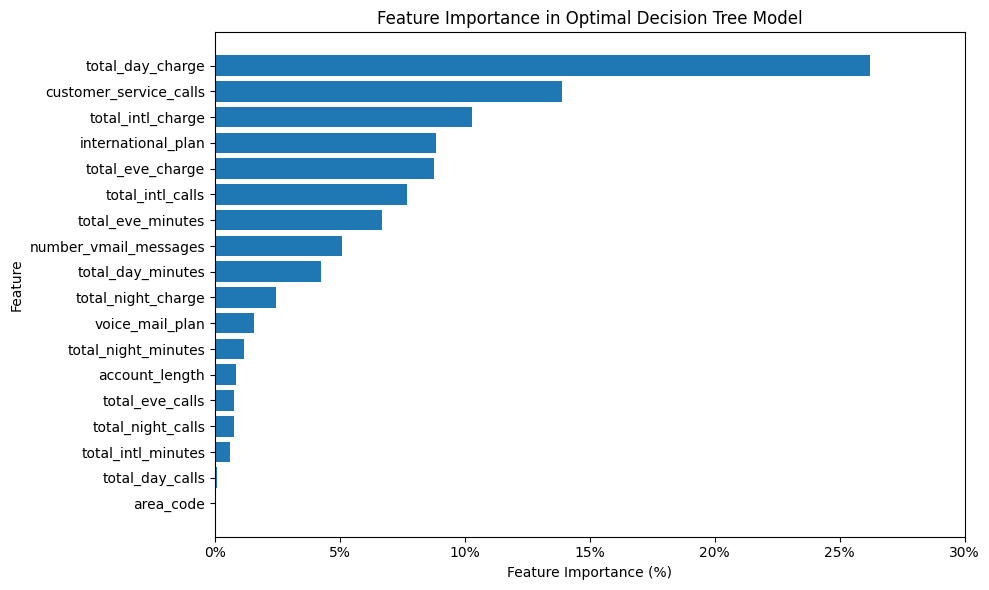

In [18]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np

# loading the preprocessed dataframe
df = joblib.load('../data/processed/preprocessed_data.pkl')

# extracting feature names (excluding the target 'churn' column)
feature_names = df.drop('churn', axis=1).columns

# obtaining the feature importances from the model
feature_importances = optimal_tree_model.feature_importances_

# creating a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# sorting the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plotting the feature importance as percentages
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])

plt.xlabel('Feature Importance (%)')

# converting feature importance values to percentages for the x-axis
plt.xticks(np.arange(0, 0.31, step=0.05), [f'{int(x*100)}%' for x in np.arange(0, 0.31, step=0.05)])
plt.ylabel('Feature')
plt.title('Feature Importance in Optimal Decision Tree Model')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('../figures/feature_importance_optimal_decision_tree.png')
plt.show()



This chart highlights the most important features used by the Decision Tree model to predict customer churn. By looking at this chart, we can see which factors contribute the most to determining whether a customer will churn. Features like total_day_charge, customer_service_calls, and international_plan have the greatest impact. This information can help the Customer Retention Team focus on these areas when developing strategies to reduce churn.

#### Key Observations:

- Total Day Charge is by far the most influential feature in predicting customer churn. This suggests that customers with higher day-time charges are more likely to churn.

- Customer Service Calls is another critical factor. The more customer service interactions a customer has, the more likely they are to churn, highlighting potential dissatisfaction.

- International Plan and Total International Charge are also significant. Customers with higher international usage or those subscribed to the international plan show a higher tendency to churn, suggesting that international service quality or cost could be pain points.

- Lower-ranked features, such as Voice Mail Plan and Area Code, have minimal importance in determining churn. These might not be as actionable in terms of business strategies for reducing churn.

- The chart shows that a small number of features are driving most of the predictive power, meaning focusing on key areas (such as customer service and high usage customers) could yield the most significant improvements in churn reduction.


### Confusion Matrix Heatmap

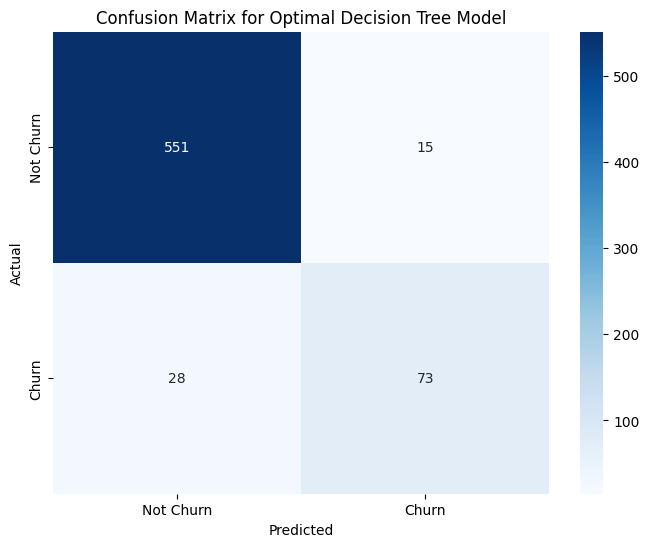

In [19]:
import seaborn as sns

# generating the confusion matrix for the optimal decision tree model
conf_matrix = confusion_matrix(y_test, y_pred_optimal)

# creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.title("Confusion Matrix for Optimal Decision Tree Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('../figures/confusion_matrix_optimal_decision_tree.png')
plt.show()



The confusion matrix heatmap allows us to visually interpret how well the model distinguishes between churn and non-churn customers. True positives (correctly predicted churners) and true negatives (correctly predicted non-churners) are shown in the diagonal of the matrix. Misclassifications are off-diagonal. This visualization helps stakeholders understand the accuracy of the model in a clear and concise way, focusing on both false positives and false negatives.

#### Key Observations:

- The model correctly classified the majority of both churn (True) and non-churn (False) customers, as indicated by the high values on the diagonal of the heatmap.

- **True Negatives (Non-Churn correctly classified)**: 555 customers were correctly identified as not churning.

- **True Positives (Churn correctly classified)**: 73 customers who actually churned were correctly identified.

- **False Negatives (Missed Churners)**: 28 churners were incorrectly classified as non-churners.

- **False Positives (Non-Churners misclassified)**: Only 15 non-churners were incorrectly classified as churners.

- The heatmap shows a balanced performance across classes.

### Comparison of Logistic Regression vs. Decision Tree Models

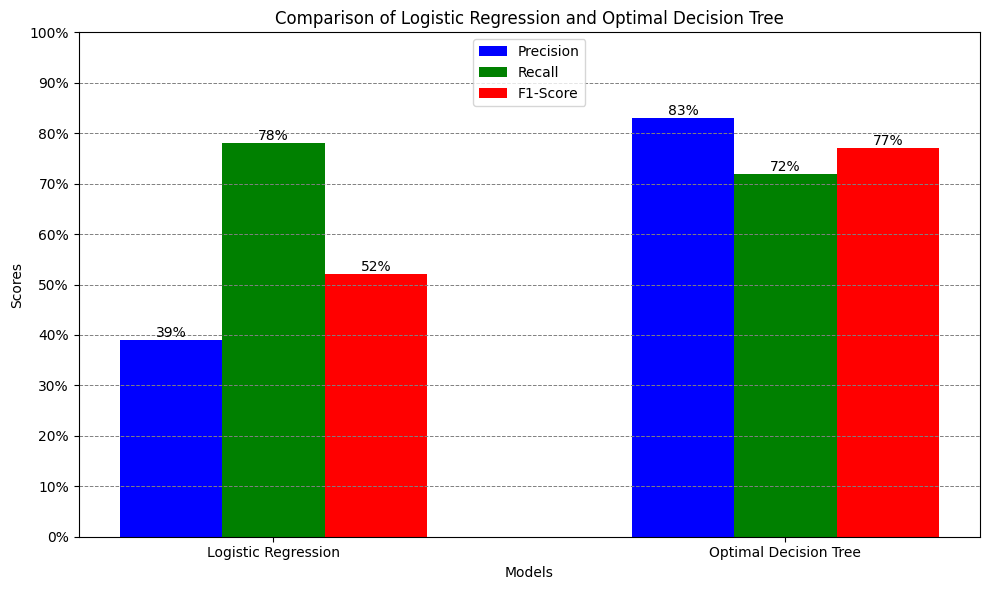

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

# performance metrics for Logistic Regression and Optimal Decision Tree
models = ['Logistic Regression', 'Optimal Decision Tree']
precision_scores = [0.39, 0.83]  # precision scores for each model
recall_scores = [0.78, 0.72]  # recall scores for each model
f1_scores = [0.52, 0.77]  # F1-scores for each model

bar_width = 0.2
index = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(index, precision_scores, bar_width, label='Precision', color='b')
bars2 = ax.bar(index + bar_width, recall_scores, bar_width, label='Recall', color='g')
bars3 = ax.bar(index + 2 * bar_width, f1_scores, bar_width, label='F1-Score', color='r')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Logistic Regression and Optimal Decision Tree')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models)
ax.legend(loc='upper center')

# formatting Y-axis as percentages
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_ylim(0, 1)

# adding values at the top of each bar
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f'{height:.0%}',
            ha='center',
            va='bottom'
        )

add_values(bars1)
add_values(bars2)
add_values(bars3)

ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')

fig.tight_layout()
plt.savefig('../figures/comparison_logreg_dtree.png')
plt.show()


#### Key Observations:
- **Accuracy**: The Decision Tree model outperforms Logistic Regression significantly in terms of accuracy (0.94 vs. 0.78), meaning it classifies a higher percentage of all customers correctly.
  
- **Precision (Churn)**: The Decision Tree model achieves much higher precision for churners (0.83) compared to Logistic Regression (0.39). This means that, with the Decision Tree model, fewer false positives (non-churners incorrectly classified as churners) are predicted, making it more reliable for focusing retention efforts.
  
- **Recall (Churn)**: Logistic Regression has a slightly higher recall for churners (0.78) compared to the Decision Tree (0.72). This suggests that Logistic Regression captures a slightly higher percentage of actual churners, though at the cost of precision.
  
- **F1-Score (Churn)**: The Decision Tree model has a much better F1-score (0.77) compared to Logistic Regression (0.52), indicating a better balance between precision and recall in identifying churners.

- **Trade-offs**: While Logistic Regression has a higher recall for churners, the Decision Tree model offers better precision and overall accuracy, which makes it more reliable for reducing false positives and optimizing retention strategies.

Overall, the Decision Tree model is better suited for this business problem because it reduces the number of unnecessary interventions on non-churners while maintaining a solid ability to identify potential churners.

## Saving Final Models

In [21]:
import joblib

save_folder = "../models/"

# final optimized decision tree model
joblib.dump(optimal_tree_model, save_folder + 'optimized_decision_tree_model.pkl')

# logistic regression model trained on SMOTE balanced data
joblib.dump(logreg, save_folder + 'logistic_regression_model.pkl')

['../models/logistic_regression_model.pkl']